In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(100_000_000_000)

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

import shared_utils
from utils import *

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt
import time
from zoneinfo import ZoneInfo

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Notes from RT Kickoff Meeting

* Incorporating trip updates?
* Trip updates can include a measure of delay…
* Relying more on internal processes…
* Trip updates also include overall schedule deviation
* Data can be missing from RT: vehicles without trips, no delay, etc…
* Evan: vehicle positions to infer delay if trip updates available, we’re implicitly deciding that we don’t trust trip updates → trusting the schedule and vehicle positions 100%
* We have trip updates someplace, just needs to be pipelined…
* In theory, update frequency should keep positions and updates close?
* Some feeds omit past events once a bus passes stop, or even future events)
* Data quality:
    * Every 20 seconds, look at next arrival from trip updates…
    * Exploratory analysis? Quicker to use+trust trip updates…


* Analysis timespan
* Confirming agency counts

#### Action items

* Work towards loading trip updates into warehouse
* Look into why there are fewer RT agencies in warehouse (~16) compared to agencies.yml (~30)
* Initial work on an algorithm to interpolate vehicle positions
* Assess how different various feeds’ implementations of trip updates are


In [2]:
## set system time

os.environ['TZ'] = 'America/Los_Angeles'
time.tzset()
time.tzname

('PST', 'PDT')

In [3]:
lbt_itp_id = 170

In [4]:
# %%sql -o lbt_positions

# # get all vehicle positions on selected dates, for the feed with itp id 170, and url number 0
# SELECT *
# FROM `cal-itp-data-infra.gtfs_rt.vehicle_positions`
# WHERE _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-01_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-02_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-03_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-04_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-05_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-06_170_0.parquet"
#     # OR _FILE_NAME="gs://gtfs-data/rt-processed/vehicle_positions/vp_2021-12-07_170_0.parquet"
# ORDER BY header_timestamp

In [5]:
# lbt_positions.to_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [6]:
lbt_positions = pd.read_parquet(f'{GCS_FILE_PATH}lbt_positions.parquet')

In [7]:
def convert_ts(ts):    
    pacific_dt = dt.datetime.fromtimestamp(ts)
    # print(pacific_dt)
    return pacific_dt

In [8]:
lbt_positions.vehicle_timestamp = lbt_positions.vehicle_timestamp.apply(convert_ts)
lbt_positions.header_timestamp = lbt_positions.header_timestamp.apply(convert_ts)

In [9]:
min_date, max_date = ('2021-11-01', '2021-12-01')
pch_routes = ('171', '172', '173', '174', '175')

In [10]:
# lbt_trips = (tbl.views.gtfs_schedule_fact_daily_trips()
#     # >> filter(_.calitp_extracted_at <= min_date, _.calitp_deleted_at > max_date)
#     >> filter(_.calitp_itp_id == lbt_itp_id)
#     >> filter(_.service_date == max_date)
#     >> filter(_.is_in_service == True)
#     >> select(_.trip_key, _.service_date)
#     >> inner_join(_, tbl.views.gtfs_schedule_dim_trips(), on = 'trip_key')
#     >> select(_.calitp_itp_id, _.calitp_url_number,
#               _.date == _.service_date,
#               _.trip_key, _.trip_id, _.route_id,
#               _.shape_id, _.calitp_extracted_at, _.calitp_deleted_at)
#     # >> filter(_.route_id.isin(pch_routes))

#     >> collect()
#     )

In [11]:
# lbt_trips.to_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [12]:
lbt_trips = pd.read_parquet(f'{GCS_FILE_PATH}lbt_trips.parquet')

In [13]:
## example of duplicate rows...

lbt_positions >> filter(_.vehicle_timestamp == 1638320532, _.vehicle_trip_id == '9288623')

,calitp_itp_id,calitp_url_number,entity_id,vehicle_id,vehicle_trip_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp


In [14]:
trips_positions_joined = (lbt_trips
                        >> filter(_.route_id.isin(pch_routes))
                        >> inner_join(_, (lbt_positions >> rename(trip_id = 'vehicle_trip_id')),
                                      on= ['trip_id', 'calitp_itp_id', 'calitp_url_number'])
                       )

In [15]:
trips_positions_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37119 entries, 0 to 37118
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   calitp_itp_id               37119 non-null  int64         
 1   calitp_url_number           37119 non-null  int64         
 2   date                        37119 non-null  object        
 3   trip_key                    37119 non-null  int64         
 4   trip_id                     37119 non-null  object        
 5   route_id                    37119 non-null  object        
 6   shape_id                    37119 non-null  object        
 7   calitp_extracted_at         37119 non-null  object        
 8   calitp_deleted_at           37119 non-null  object        
 9   entity_id                   37119 non-null  object        
 10  vehicle_id                  0 non-null      object        
 11  vehicle_timestamp           37119 non-null  datetime64

In [16]:
trips_positions_joined

,calitp_itp_id,calitp_url_number,date,trip_key,trip_id,route_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp
0,170,0,2021-12-01,7837859572949426434,9288675,172,1720091,2021-09-16,2099-01-01,2522,None,2021-12-01 05:41:00,33.782784,-118.16875,2021-12-01 05:41:24
1,170,0,2021-12-01,7837859572949426434,9288675,172,1720091,2021-09-16,2099-01-01,2522,None,2021-12-01 05:41:00,33.782784,-118.16875,2021-12-01 05:41:54
2,170,0,2021-12-01,7837859572949426434,9288675,172,1720091,2021-09-16,2099-01-01,2522,None,2021-12-01 05:41:00,33.782784,-118.16875,2021-12-01 05:41:54
3,170,0,2021-12-01,7837859572949426434,9288675,172,1720091,2021-09-16,2099-01-01,2522,None,2021-12-01 05:42:00,33.782610,-118.16676,2021-12-01 05:42:24
4,170,0,2021-12-01,7837859572949426434,9288675,172,1720091,2021-09-16,2099-01-01,2522,None,2021-12-01 05:42:00,33.782610,-118.16676,2021-12-01 05:42:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37114,170,0,2021-12-01,-5614473860858448080,9288739,173,1730122,2021-09-16,2099-01-01,2914,None,2021-11-30 17:25:53,33.912865,-118.10376,2021-11-30 17:26:38
37115,170,0,2021-12-01,-5614473860858448080,9288739,173,1730122,2021-09-16,2099-01-01,2914,None,2021-11-30 17:26:53,33.912865,-118.10377,2021-11-30 17:27:08
37116,170,0,2021-12-01,-5614473860858448080,9288739,173,1730122,2021-09-16,2099-01-01,2914,None,2021-11-30 17:26:53,33.912865,-118.10377,2021-11-30 17:27:38
37117,170,0,2021-12-01,-5614473860858448080,9288739,173,1730122,2021-09-16,2099-01-01,2914,None,2021-11-30 17:26:53,33.912865,-118.10377,2021-11-30 17:27:38


In [17]:
trips_positions_joined = gpd.GeoDataFrame(trips_positions_joined,
                                geometry=gpd.points_from_xy(trips_positions_joined.vehicle_position_longitude,
                                                            trips_positions_joined.vehicle_position_latitude),
                                crs=shared_utils.geography_utils.WGS84).to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [18]:
# trips_positions_joined.geometry = trips_positions_joined.buffer(50)

In [19]:
# list(trips_positions_joined.trip_id.unique())

In [20]:
one_trip = trips_positions_joined >> filter(_.trip_id == '9288623')

In [21]:
# simple_map(one_trip, 'vehicle_timestamp')

In [22]:
shared_utils.geography_utils.make_routes_shapefile?

Signature:
shared_utils.geography_utils.make_routes_shapefile(
    ITP_ID_LIST=[],
    CRS='EPSG:4326',
)
Docstring:
Parameters:
ITP_ID_LIST: list. List of ITP IDs found in agencies.yml
CRS: str. Default is WGS84, but able to re-project to another CRS.

Returns a geopandas.GeoDataFrame, where each line is the operator-route-line geometry.
File:      ~/data-analyses/_shared_utils/shared_utils/geography_utils.py
Type:      function


In [23]:
lbt_routelines = shared_utils.geography_utils.make_routes_shapefile(['170']) ## LBT

In [24]:
lbt_routelines = lbt_routelines.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [25]:
# lbt_routelines.geometry = lbt_routelines.buffer(50)

In [26]:
route = lbt_routelines >> filter(_.shape_id == '1750012') >> select(-_.calitp_extracted_at)

In [27]:
simple_map(route)

Map(center=[33.78808728742526, -118.1690122550757], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Shapely Linear Referencing

[methods](https://shapely.readthedocs.io/en/latest/manual.html#object.interpolate)

In [28]:
import shapely

In [29]:
one_trip = one_trip >> distinct(_.trip_id, _.vehicle_timestamp, _keep_all=True)

In [30]:
one_trip.head(3)

,calitp_itp_id,calitp_url_number,date,trip_key,trip_id,route_id,shape_id,calitp_extracted_at,calitp_deleted_at,entity_id,vehicle_id,vehicle_timestamp,vehicle_position_latitude,vehicle_position_longitude,header_timestamp,geometry
0,170,0,2021-12-01,1553149201202261125,9288623,175,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:02:12,33.782070,-118.11569,2021-11-30 17:02:37,POINT (174550.467 -468602.675)
1,170,0,2021-12-01,1553149201202261125,9288623,175,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:03:13,33.782097,-118.11948,2021-11-30 17:03:37,POINT (174199.373 -468606.652)
2,170,0,2021-12-01,1553149201202261125,9288623,175,1750012,2021-09-16,2099-01-01,2901,None,2021-11-30 17:04:13,33.782130,-118.12217,2021-11-30 17:04:37,POINT (173950.148 -468607.933)


In [31]:
route

,calitp_itp_id,shape_id,geometry
36,170,1750012,"LINESTRING (174623.499 -468608.211, 174620.963..."


In [32]:
route_geo = route.geometry.iloc[0]

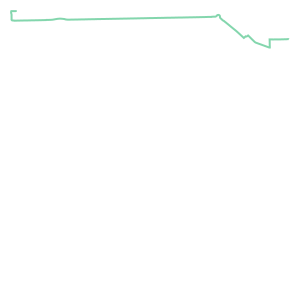

In [33]:
route_geo

In [34]:
trip_pt = one_trip.geometry.iloc[0]

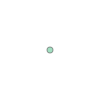

In [35]:
trip_pt

In [36]:
route_geo.project(trip_pt)

74.93606858573466

In [37]:
## convert times to DTs...

In [38]:
trip_pt2 = one_trip.geometry.iloc[1]

In [39]:
dist = route_geo.project(trip_pt2) - route_geo.project(trip_pt)

In [40]:
td = one_trip.vehicle_timestamp.iloc[1] - one_trip.vehicle_timestamp.iloc[0]

In [41]:
MPH_PER_MPS = 2.237

In [42]:
mps = dist / td.seconds ## meters/second

In [43]:
mps * MPH_PER_MPS ## a believable value for transit!

12.892640971929948

In [44]:
trip_st = (tbl.gtfs_schedule.stop_times()
     >> filter(_.calitp_itp_id == 170)
     >> filter(_.trip_id == '9288623')
     >> mutate(stop_sequence = _.stop_sequence.astype(int)) ## in SQL!
     >> arrange(_.stop_sequence)
     >> collect()
    )

In [45]:
## stop times canonical; interpolate positions to hit
## geocode stops, linear reference

In [46]:
trip_st.head(3)

,calitp_itp_id,calitp_url_number,trip_id,stop_id,stop_sequence,arrival_time,departure_time,stop_headsign,pickup_type,drop_off_type,continuous_pickup,continuous_drop_off,shape_dist_traveled,timepoint,calitp_extracted_at
0,170,0,9288623,1026,1,16:56:00,16:56:00,None,0,0,None,None,0.0,1,2021-12-17
1,170,0,9288623,1027,2,16:58:10,16:58:10,None,0,0,None,None,0.311,0,2021-12-17
2,170,0,9288623,0540,3,17:00:17,17:00:17,None,0,0,None,None,0.616,0,2021-12-17


In [71]:
class VehiclePositionsTrip:
    '''Trip data and useful methods for analyzing GTFS-RT vehicle positions data'''
    
    def __init__(self, vp_gdf):
        assert vp_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        
        self.date = vp_gdf.date.iloc[0]
        self.trip_id = vp_gdf.trip_id.iloc[0]
        self.route_id = vp_gdf.route_id.iloc[0]
        self.shape_id = vp_gdf.shape_id.iloc[0]
        self.entity_id = vp_gdf.entity_id.iloc[0]
        self.vehicle_id = vp_gdf.vehicle_id.iloc[0]
        self.calitp_itp_id = vp_gdf.calitp_itp_id.iloc[0]
        self.calitp_url_number = vp_gdf.calitp_url_number.iloc[0]
        self.vehicle_positions = vp_gdf >> select(_.vehicle_timestamp,
                                              _.header_timestamp,
                                              _.geometry)
        
    def linear_reference(self):
        self.vehicle_positions['shape_meters'] = (self.vehicle_positions.geometry
                                        .apply(lambda x: self.shapes.geometry.iloc[0].project(x)))
        self.vehicle_positions['last_time'] = self.vehicle_positions.vehicle_timestamp.shift(1)
        self.vehicle_positions['last_loc'] = self.vehicle_positions.shape_meters.shift(1)
        self.vehicle_positions['secs_from_last'] = self.vehicle_positions.vehicle_timestamp - self.vehicle_positions.last_time
        self.vehicle_positions.secs_from_last = (self.vehicle_positions.secs_from_last
                                        .apply(lambda x: x.seconds))
        self.vehicle_positions['meters_from_last'] = (self.vehicle_positions.shape_meters
                                                      - self.vehicle_positions.last_loc)
        self.vehicle_positions['speed_from_last'] = (self.vehicle_positions.meters_from_last
                                                     / self.vehicle_positions.secs_from_last)
    
    def attach_shape(self, shape_gdf):
        assert shape_gdf.crs == shared_utils.geography_utils.CA_NAD83Albers
        assert shape_gdf.calitp_itp_id.iloc[0] == self.calitp_itp_id
        
        self.shapes = (shape_gdf
                        >> filter(_.shape_id == self.shape_id)
                        >> select(_.shape_id, _.geometry))
        self.linear_reference()
        
#     def position_at_time(self, dt):
        
    def time_at_position(self, desired_position):
        
        next_point = (self.vehicle_positions
              >> filter(_.shape_meters > desired_position)
              >> filter(_.shape_meters == _.shape_meters.min())
             )
        bounding_points = gdf.loc[next_point.index - 1].append(next_point)
        meters_to_next = bounding_points.iloc[-1].shape_meters - desired_location
        seconds_to_next = meters_to_next / bounding_points.iloc[-1].speed_from_last
        td_to_next = dt.timedelta(seconds=seconds_to_next)
        est_dt = bounding_points.iloc[-1].vehicle_timestamp - td_to_next
        
        return est_dt

In [48]:
one_trip.crs == shared_utils.geography_utils.CA_NAD83Albers

True

In [49]:
shared_utils.geography_utils.CA_NAD83Albers

'EPSG:3310'

In [50]:
test1 = VehiclePositionsTrip(one_trip)

In [51]:
test1.vehicle_positions.head(2)

,vehicle_timestamp,header_timestamp,geometry
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.467 -468602.675)
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.373 -468606.652)


In [52]:
lbt_routelines.head(2)

,calitp_itp_id,shape_id,calitp_extracted_at,geometry
0,170,10069,2021-12-17,"LINESTRING (161216.993 -459406.837, 161188.049..."
1,170,10070,2021-12-17,"LINESTRING (165555.589 -461447.899, 165529.874..."


In [53]:
test1.attach_shape(lbt_routelines)

In [54]:
gdf = test1.vehicle_positions

In [55]:
gdf.head(3)

,vehicle_timestamp,header_timestamp,geometry,shape_meters,last_time,last_loc,secs_from_last,meters_from_last,speed_from_last
0,2021-11-30 17:02:12,2021-11-30 17:02:37,POINT (174550.467 -468602.675),74.936069,NaT,NaN,NaN,NaN,NaN
1,2021-11-30 17:03:13,2021-11-30 17:03:37,POINT (174199.373 -468606.652),426.501155,2021-11-30 17:02:12,74.936069,61.0,351.565087,5.763362
2,2021-11-30 17:04:13,2021-11-30 17:04:37,POINT (173950.148 -468607.933),676.459161,2021-11-30 17:03:13,426.501155,60.0,249.958006,4.165967


In [56]:
desired_location = 500

In [57]:
next_point = (gdf
              >> filter(_.shape_meters > desired_location)
              >> filter(_.shape_meters == _.shape_meters.min())
             )
bounding_points = gdf.loc[next_point.index - 1].append(next_point)

In [59]:
meters_to_next = bounding_points.iloc[-1].shape_meters - desired_location

In [60]:
meters_to_next

176.45916137663323

In [63]:
seconds_to_next = meters_to_next / bounding_points.iloc[-1].speed_from_last

In [64]:
seconds_to_next

42.35731375286435

In [67]:
td_to_next = dt.timedelta(seconds=seconds_to_next)

In [68]:
est_dt = bounding_points.iloc[-1].vehicle_timestamp - td_to_next

In [70]:
desired_location

500

In [69]:
est_dt

Timestamp('2021-11-30 17:03:30.642686')